# data.world
## 2010-2015 NYC Crime Data

> #### Setup  

> Before running data.world notebooks for the first time, you'll need to:  
1. Install data.world's Python package, including optional `pandas` dependencies: 
```shell
pip install git+git://github.com/datadotworld/data.world-py.git#egg=project[pandas]
```
1. Obtain an API access token at https://data.world/settings/advanced
1. Store API access token using the `dw` command-line tool: 
```shell
dw configure
```

> Once your environment is set up, these steps do not need to be repeated for other data.world notebooks.

In [1]:
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

import datadotworld as dw
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from mpl_toolkits.basemap import Basemap
from datetime import timedelta, date
import datetime

In [2]:
# Datasets are referenced by their path
dataset_key = 'carolinadata/2010-2015-nyc-crime-data'

# Or simply by their URL
dataset_key = 'https://data.world/carolinadata/2010-2015-nyc-crime-data'

In [3]:
# Load dataset (onto the local file system)
dataset_local = dw.load_dataset(dataset_key)  # cached under ~/.dw/cache

In [4]:
# See what is in it
dataset_local.describe('nypd_complaint_data_historic_short')

{'format': 'csv',
 'name': 'nypd_complaint_data_historic_short',
 'path': 'data/nypd_complaint_data_historic_short.csv',
 'schema': {'fields': [{'description': 'Randomly generated persistent ID for each complaint',
    'name': 'cmplnt_num',
    'rdfType': 'http://www.w3.org/2001/XMLSchema#integer',
    'title': 'CMPLNT_NUM',
    'type': 'integer'},
   {'description': 'Exact date of occurrence for the reported event (or starting date of occurrence, if CMPLNT_TO_DT exists)',
    'name': 'cmplnt_fr_dt',
    'rdfType': 'http://www.w3.org/2001/XMLSchema#date',
    'title': 'CMPLNT_FR_DT',
    'type': 'date'},
   {'description': 'Exact time of occurrence for the reported event (or starting time of occurrence, if CMPLNT_TO_TM exists)',
    'name': 'cmplnt_fr_tm',
    'rdfType': 'http://www.w3.org/2001/XMLSchema#time',
    'title': 'CMPLNT_FR_TM',
    'type': 'time'},
   {'description': 'Ending date of occurrence for the reported event, if exact time of occurrence is unknown',
    'name': 'cmp

In [24]:
#Using pandas dataframes
nyc = dataset_local.dataframes['nypd_complaint_data_historic_short']

#Ensure dates are actually dates
nyc['cmplnt_fr_dt'] = pd.to_datetime(nyc['cmplnt_fr_dt'], errors = 'coerce')
nyc[['latitude', 'longitude']]

moon = pd.read_csv('moon.csv')
moon['date'] = pd.to_datetime(moon['date'], errors = 'coerce')

#Max value of hexbin bin over entire data, so bins are relative across plots
maxVal = 1

In [25]:
nyc[['cmplnt_fr_dt', 'latitude', 'longitude']].head()

,cmplnt_fr_dt,latitude,longitude
0,2015-12-31,40.828848,-73.916661
1,2015-12-31,40.697338,-73.784557
2,2015-12-31,40.802607,-73.945052
3,2015-12-31,40.654549,-73.726339
4,2015-12-31,40.738002,-73.987891


In [26]:
moon.head()

,date,time,phase,phaseid,datetime,timestamp,friendlydate
0,2010-01-07,05:39 AM,Last Quarter,4,2010-01-07 05:39:00,1262860740,"January 7, 2010"
1,2010-01-15,02:11 AM,New Moon,1,2010-01-15 02:11:00,1263539460,"January 15, 2010"
2,2010-01-23,05:53 AM,First Quarter,2,2010-01-23 05:53:00,1264243980,"January 23, 2010"
3,2010-01-30,01:18 AM,Full Moon,3,2010-01-30 01:18:00,1264832280,"January 30, 2010"
4,2010-02-05,06:48 PM,Last Quarter,4,2010-02-05 18:48:00,1265413680,"February 5, 2010"


In [27]:
#The map
bm = Basemap(projection='mill',llcrnrlat=40.47,urcrnrlat=40.92,\
        llcrnrlon=-74.26, urcrnrlon=-73.7, lat_ts=40.5,resolution='f')

In [31]:
def createNYCMap(x,y,t=None, m = bm):
    global maxVal
    
    
    if t is not None:
        gs = gridspec.GridSpec(4,2,
                       width_ratios=[5,1])
    
        plt.subplot(gs[:, 0])
    
        #m = Basemap(projection='mill',llcrnrlat=40.47,urcrnrlat=40.92,\
        #    llcrnrlon=-74.26, urcrnrlon=-73.7, lat_ts=40.5,resolution=res)
    
    mx,my = m(y,x)

    hb = m.hexbin(mx,my, gridsize=50, 
                  C=np.ones_like(y, dtype=np.float) / maxVal,
                  reduce_C_function=np.sum,
                  mincnt = 1, cmap=plt.cm.jet, bins='log')

    maxVal = max(hb.get_array().max(), maxVal)
    m.drawcoastlines()
    m.fillcontinents(zorder = 0)
    m.drawcountries(linewidth=.2)
    
    if t is not None:
        plt.title(t['phase'] + ' of ' + t['date'].strftime("%B %d, %Y"))
    
        #Moon images
        for i in range(0,4):
            plt.subplot(gs[i, 1])
            img = mpimg.imread(str(i+1) + '.png')
            if i+1 == t['phaseid']:
                fig = plt.imshow(img)
            else:
                fig = plt.imshow(img, alpha = .4)   
            fig.axes.get_xaxis().set_visible(False)
            fig.axes.get_yaxis().set_visible(False)

    fig1 = plt.gcf()
    plt.show()
    
    #Saving for making the gif
    #fig1.savefig('figis/' + str(t['date']) + '.png')
    
    return plt

In [32]:
#Util functions, seem pretty self-explanatory
def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)
        
def location_of_complaints_on_date(d):
    return nyc[nyc['cmplnt_fr_dt'] == d][['latitude', 'longitude']].dropna(subset=['latitude', 'longitude'])

def location_of_complaints_around_moons(dates):
    date_list = []
    for d in dates:
        date_list += [d - datetime.timedelta(days=x) for x in range(0, 4)] + [d + datetime.timedelta(days=x) for x in range(1, 4)]
    return nyc[nyc['cmplnt_fr_dt'].isin(date_list)][['latitude', 'longitude']].dropna(subset=['latitude', 'longitude'])

def location_of_complaints_around_moon(d):
    date_list = [d - datetime.timedelta(days=x) for x in range(0, 4)] + [d + datetime.timedelta(days=x) for x in range(1, 4)]
    return nyc[nyc['cmplnt_fr_dt'].isin(date_list)][['latitude', 'longitude']].dropna(subset=['latitude', 'longitude'])

def to_lists(df):
    return np.array(df['latitude']), np.array(df['longitude'])

def quick_plot(row):
    d = row['date']
    x,y = to_lists(location_of_complaints_around_moon(d))
    return createNYCMap(x,y,t=row)

start_date = date(2010, 1, 1)
end_date = date(2015, 12, 31)

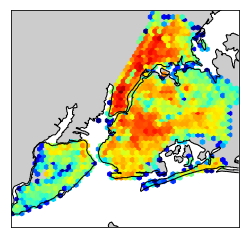

<module 'matplotlib.pyplot' from '/Users/MarkMolinaro/anaconda/envs/cdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [33]:
#must run this one first to correctly set maxVal
allcomplaints = moon['date'].tolist()
x,y = to_lists(location_of_complaints_around_moons(allcomplaints))
createNYCMap(x,y)

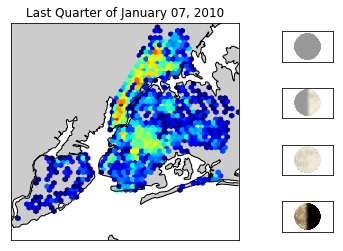

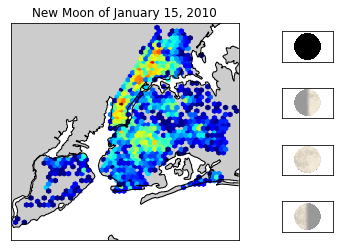

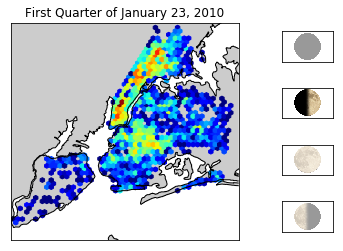

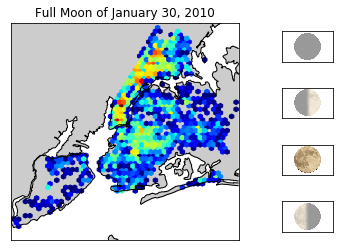

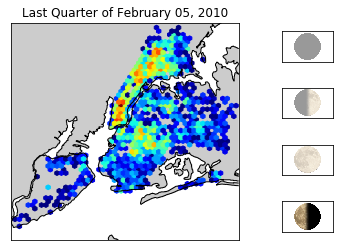

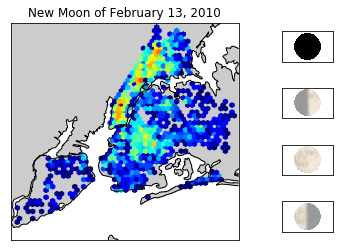

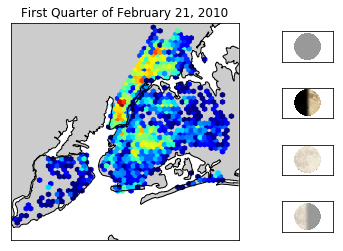

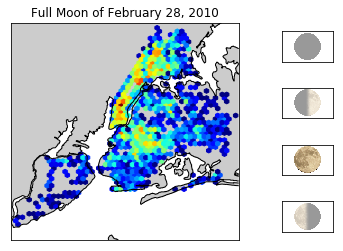

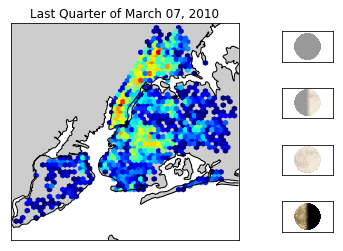

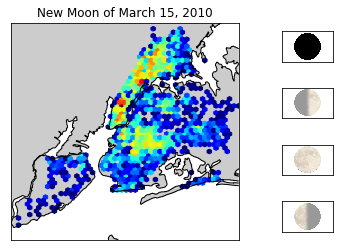

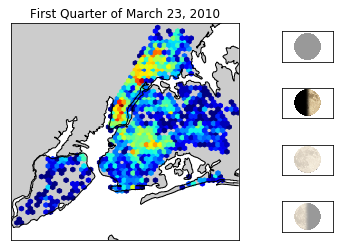

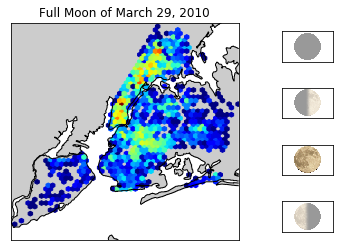

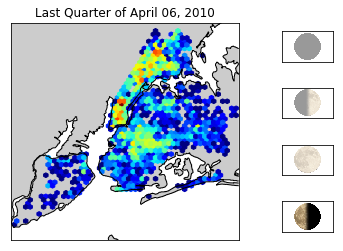

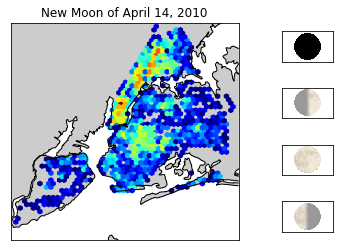

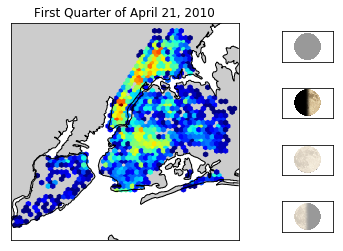

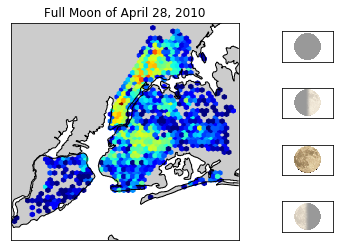

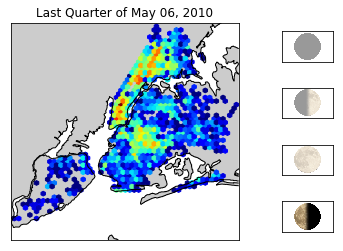

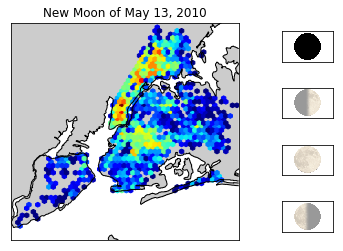

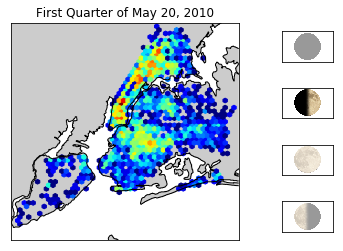

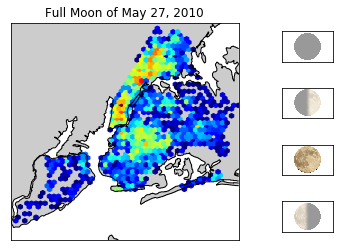

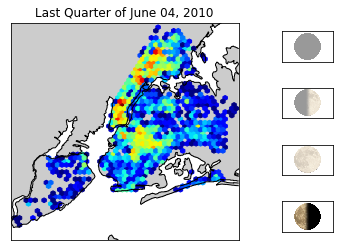

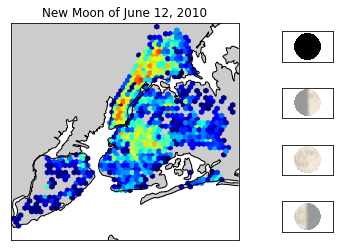

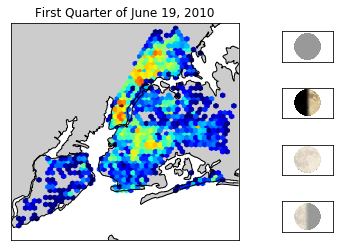

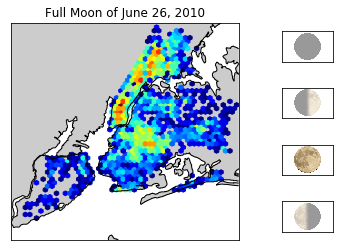

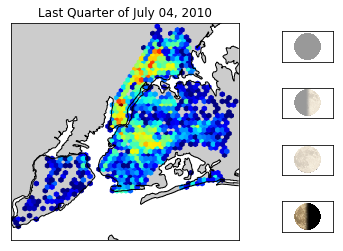

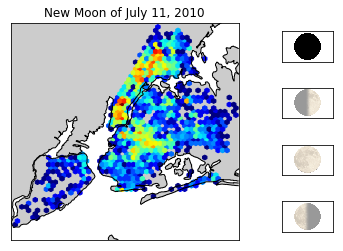

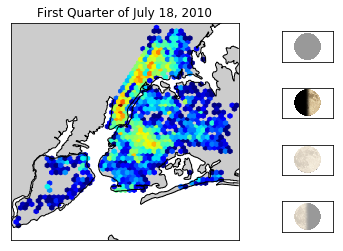

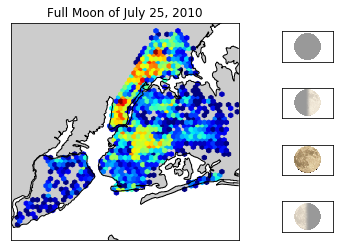

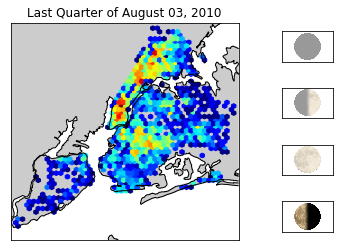

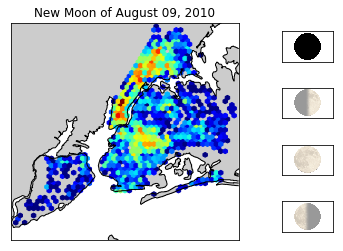

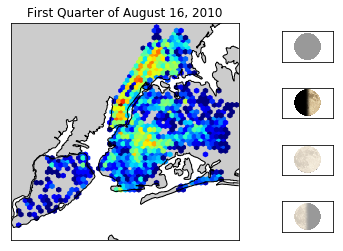

KeyboardInterrupt: 

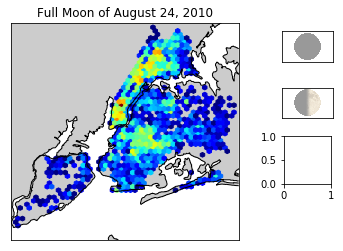

In [41]:
#Generate each plot
for _, row in moon.iterrows():
    quick_plot(row)

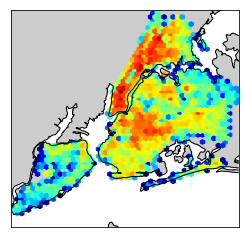

<module 'matplotlib.pyplot' from '/Users/MarkMolinaro/anaconda/envs/cdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [35]:
#Summation of all full moons
fulls = moon[moon['phase']=='Full Moon']['date'].tolist()
x,y = to_lists(location_of_complaints_around_moons(fulls))
createNYCMap(x,y)

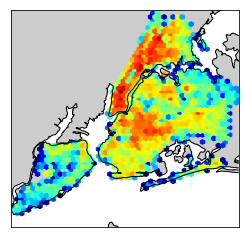

<module 'matplotlib.pyplot' from '/Users/MarkMolinaro/anaconda/envs/cdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [37]:
fulls = moon[moon['phase']=='Full Moon']['date'].tolist()
x,y = to_lists(location_of_complaints_around_moons(fulls))
createNYCMap(x, y)

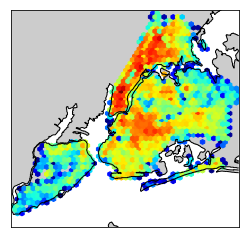

<module 'matplotlib.pyplot' from '/Users/MarkMolinaro/anaconda/envs/cdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [38]:
news = moon[moon['phase']=='New Moon']['date'].tolist()
x,y = to_lists(location_of_complaints_around_moons(news))
createNYCMap(x, y)

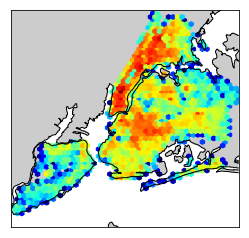

<module 'matplotlib.pyplot' from '/Users/MarkMolinaro/anaconda/envs/cdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [39]:
fq = moon[moon['phase']=='First Quarter']['date'].tolist()
x,y = to_lists(location_of_complaints_around_moons(fq))
createNYCMap(x, y)

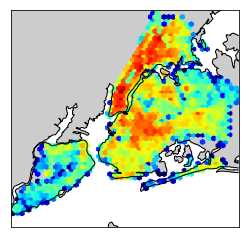

<module 'matplotlib.pyplot' from '/Users/MarkMolinaro/anaconda/envs/cdc/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [40]:
lq = moon[moon['phase']=='Last Quarter']['date'].tolist()
x,y = to_lists(location_of_complaints_around_moons(lq))
createNYCMap(x, y)